In [14]:
from utils_review import *

### Evolved clock and switch


In [15]:
def HillA(x,t,n):
    return x**n/(x**n+t**n)


def HillR(x,t,n):
    return 1/(1+(x/t)**n)

def deriv(vec,history,t):
    e = vec[:,0]
    r = vec[:,1]

    de=-0.853818252561968*e;
    dr=-0.9758821074508301*r
    
    d_e=48
    delayed=np.zeros((n_cells,3))
    #print(t,history.shape)
    if (t>d_e):
        delayed=history[t-48]

    delayed_e=delayed[:,0]
    delayed_r=delayed[:,1]
    delayed_g=delayed[:,2]
    rate=0.717566*np.maximum(HillA(delayed_e,0.321251,3),HillA(delayed_g,0.067799,4.354903))*HillR(delayed_r,0.494191,4.532086)
    de=de+rate
            
            
    d_r=392
    delayed=np.zeros((n_cells,3))
    if (t>d_r):
        delayed=history[t-392]

    delayed_e=delayed[:,0]
    delayed_r=delayed[:,1]
    delayed_g=delayed[:,2]
    rate=0.942165*HillA(delayed_g,0.504665,3.213598)*HillR(delayed_r,0.115629,4.522007);
    dr=dr+rate;

    

    dg=0*e
    return np.array([de, dr, dg]).transpose()


def compute_g(t,param):
    n_cells= param["n_cells"]
    elongation_speed = param["elongation_speed"]
    ap_positions = np.linspace(0.0, 1.0, n_cells)
    
    g = (1.0-ap_positions)*n_cells -elongation_speed*t
    g[g > 1.] = 1.
    g[g < 0.] = 0.
    
    return g


In [16]:
def integrate_evolved(init_vec, time_param, ode_param):

    init_t = time_param["init_t"]
    total_t = time_param["total_t"]
    dt = time_param["dt"]
    times = np.arange(init_t, init_t+total_t, dt)
    
    counter = 0
    n_skr = time_param["n_skr"]  # number of Steps modulo which you want to Keep the Results


    
    vec = init_vec
    g = compute_g(0,ode_param)
    vec[:,2]=g
    results = [vec]
    history=[vec]
    times_plot = [init_t]



    for t in range(len(times[1:])):
        

        vec = vec +deriv(vec,history,t)*dt
        g = compute_g(t*dt,ode_param)
        vec[:,2]=g
        #print(vec)
        history.append(vec)
        counter += 1
        if (counter %n_skr == 0):
            results.append(vec)
            times_plot.append(t*dt)
        

    results = np.array(results)
    times_plot = np.array(times_plot)
    
    return results, times_plot

In [17]:
time_param = {
    "init_t" : 0.,
    "total_t" : 200.,
    "dt" : 0.01,
    "n_skr" : 10  # number of Steps modulo which you want to Keep the Results
}

ode_param = {
    
    "dif_coef" : 0.01,
    "n_cells" : 50,
    "elongation_speed" : 0.6,
}

n_cells= ode_param["n_cells"]
init_vec = 0.1*np.ones((n_cells, 3))

names_plot = ['E', 'R', 'G']
colors_plot = ['tab:red', 'tab:blue', 'tag:green']
results,times_plot = integrate_evolved(init_vec, time_param, ode_param)

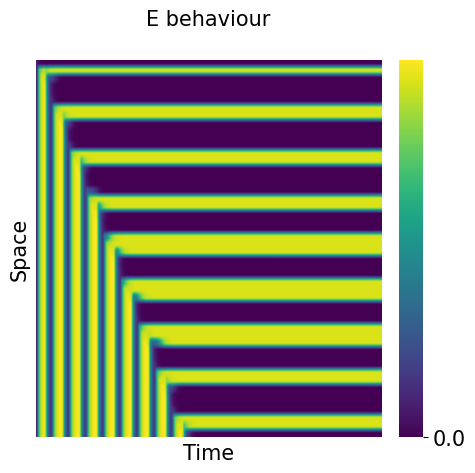

In [18]:
plot_kymo(results[:,:,0].transpose(), 'E behaviour',colorbar=True, cb_ticks=[-0.9, 0., 0.9])

## Jutras Dube et al Model

In [19]:
def dynamic(vec):
    
    y = vec[:,0]
    z = vec[:,1]
    r = np.sqrt(y*y+z*z)
    
    dy = y*(1.-r) -z
    dz = z*(1.-r) +y
    
    return np.array([dy, dz]).transpose()



def static(vec):
    
    y = vec[:,0]
    z = vec[:,1]
    
    dy = y*(1.-y*y)
    dz = -z
    
    return np.array([dy, dz]).transpose()



def intermediate(vec):
    
    y = vec[:,0]
    z = vec[:,1]
    
    dy = -y
    dz = -z
    
    return np.array([dy, dz]).transpose()



def dvec(vec, g, param):
    
    g = np.array([g, g]).transpose()
    ng = param["ng"]
    if_interm = param["if_interm"]
    
    return g**ng*dynamic(vec) +(1.-g)**ng*static(vec) +if_interm*g*(1.-g)*intermediate(vec)

In [20]:
def compute_g_geom(t, param):
    
    x_osc = param["x_osc"]
    s = param["s"]
    v = param["v"]
    positions = np.linspace(0.0, 1.0, param["n_cells"])
    
    g = np.exp(s*(1.0-positions +x_osc -v*t))
    g[g > 1.] = 1.
    
    return g

In [21]:
def integrate_geom(init_conc, param):

    # Set the integration parameters
    total_t = param["total_t"]
    dt = param["dt"]
    times = np.arange(0., total_t, dt)
    times_plot = [0.]

    vec = init_vec
    results = [vec]
    g = compute_g_geom(0., param)
    g_gradient = [g]
    omega = param["omega"]
    noise_level = param["noise"]
    counter = 0
    n_steps_keep_results = param["n_steps_keep_results"]

    
    # Perform the integration
    for t in times[1:]:
        
        # Compute noise
        noise = noise_level*np.random.normal(loc=0., scale=1., size=vec.shape)
        
        # Introduce noise in the cells at a fixed rate
        x_posterior_psm = int(t*param["v"]*param["n_cells"])
        if (x_posterior_psm < param["n_cells"]):    
            noise[x_posterior_psm:] = noise[x_posterior_psm]
            
        # Update the state vector
        vec = vec +dvec(vec, g, param)*dt +noise*np.sqrt(dt/omega)
        g = compute_g_geom(t, param)
           
        counter += 1
        if (counter %n_steps_keep_results == 0):
            results.append(vec)
            g_gradient.append(g)
            times_plot.append(t)
        

    # Output the results
    results = np.array(results)
    g_gradient = np.array(g_gradient)
    times_plot = np.array(times_plot)
    
    return results, g_gradient, times_plot

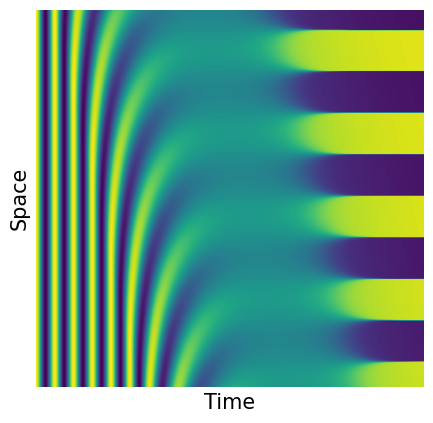

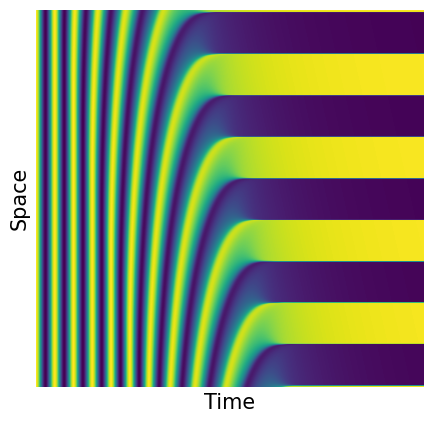

In [22]:
param ={
    
    # ODE parameters
    "ng"        : 3,
    "if_interm" : 1.,
    
    # Morphogen gradient parameters
    "x_osc"   : 0.2,
    "s"       : 0.5,
    "v"       : 0.035,
    "n_cells" : 500,
    
    # Integration parameters
    "total_t"              : 130.,
    "dt"                   : 0.01,
    "n_steps_keep_results" : 1,
    "omega"                : 1000.,
    "noise"                : 0.                
}


init_vec = np.zeros((param["n_cells"], 2))
init_vec[:,0] = 1.


# Gene-free model with a Hopf bifurcation (Model 1)
param["ng"] = 3
param["if_interm"] = 1.
results_noise_Hopf, g_gradient_noise_Hopf, times_plot_noise_Hopf = integrate_geom(init_vec, param)
plot_kymo(results_noise_Hopf[:,:,0].transpose())


# Gene-free model with a SNIC bifurcation (Model 2)
param["ng"] = 1
param["if_interm"] = 0.
results_noise_SNIC, g_gradient_noise_SNIC, times_plot_noise_SNIC = integrate_geom(init_vec, param)
plot_kymo(results_noise_SNIC[:,:,0].transpose())

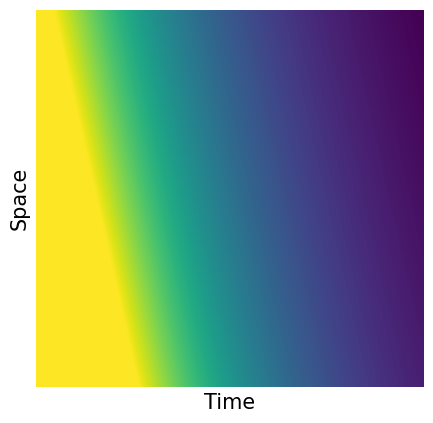

In [23]:
plot_kymo(g_gradient_noise_SNIC.transpose())